# Homework 5
#### Assigned: 2019-04-26
#### Due EOD: 2019-05-03

Based on Lecture 12
+ The student fills in the <...> fields.  
+ The student can create as many new cells as necessary in the solution sections.

**Make sure you have activated the correct python envorinment**

#### Name:  Xiaowen Wang
#### NetID: xw1831

## Problem 1 (20 points)

A CNN has the following structure:  

Conv2D_Layer -> Pooling_Layer -> Flattening_Layer -> Dense_Layer

+ input shape (size of the image): $M_1 \times M_2$
+ conv2d kernel with bias
+ conv2d kernel shape: $K_1 \times K_2$  
+ conv2d padding: same  
+ conv2d stride in both dimensions: 1  
+ conv2d filters (number of kernels): $F$
+ pooling layer size: $P_1 \times P_2$ (assume $P_{1,2}$ is a divisor of $M_{1,2}$) 
+ pooling padding: same
+ pooling stride in both dimensions: 1
+ flattening layer  
+ dense layer with bias
+ dense layer units (number of nodes): $H$

Write down the expression that gives the total number of parameters to be fitted $Q$ in terms of the above values.

## Solution 1

Conv2D_Layer Parameters:
$$N_1=(K_1\times K_2 +1)\times F$$
Pooling_Layer Output Shape:
$$(M_1-P_1+1)\times(M_2-P_2+1)$$
Flattening_Layer Output:
$$N_2=(M_1-P_1+1)\times(M_2-P_2+1)\times F$$
Dense_Layer Parameters:
$$N_3=H\times (N_2+1)$$
**Total number of parameters**:
\begin{equation}
\begin{aligned}
Q&=N_1+N_3\\
&=(K_1\times K_2 +1)\times F+[(M_1-P_1+1)\times(M_2-P_2+1)\times F+1]\times H\\
&=[(K_1\times K_2 +1)+(M_1-P_1+1)\times(M_2-P_2+1)\times H]\times F+H
\end{aligned}
\end{equation}

## Problem 2 (80 points) 

Use LSTM to analyze S&P 500 returns over the period 2004-2006.

The data file "stock-treasury-2004_2006.csv", to be found in the "Data" folder, contains the following:  
+ TREAS_3M: the yield of the 3-month treasury note in percent (i.e 2.1 means 2.1%)
+ Adjusted close price of ten major stocks: GM, F, UTX, CAT, MRK, PFE, IBM, MSFT, C, XOM
+ SP: The S&P 500 equity index level at the close of the trading day  

**Do the following:**  

Use the pandas read_csv function to read the Date and SP columns in a data frame called "sp_df".  
Rename the "SP" column into "ClosePx" in the same read_csv call.  
Compute the close-to-close index returns as:  $r_t = P_{t+1}/P_t - 1$ and add them as a new column "DailyRet".  
It is recommended to express all daily returns in basis points (10,000 bps = 100% = 1)

We want to train an RNN that looks back $M$ days and forecasts forward $N$ days.  
Therefore the RNN will use return sequences of size $M$, and targets of size $N$.  

Reformat the return data suitable for RNN processing as follows.  
From the "DailyRet" column of "sp_df", create a data input matrix $X$ containing rows as below:    
$$r_0, r_1, r_2, \ldots, r_{M-1}$$  
$$r_1, r_2, r_3, \ldots, r_{M}$$  
$$r_2, r_3, r_4, \ldots, r_{M+1}$$  
$$\ldots$$
From the "DailyRet" column of "sp_df", create also a target matrix $y$ containing rows as below:
$$ r_{M}, r_{M+1}, \ldots, r_{M+N-1}$$
$$ r_{M+1}, r_{M+2}, \ldots, r_{M+N}$$
$$ r_{M+2}, r_{M+3}, \ldots, r_{M+N+1}$$
$$\ldots$$

Set $M=16$ and $N=4$.  
Build an RNN with two LSTM cells and train it on the first 607 sequences.  
This means that the training set contains returns with the latest date of 2016-05-31.    
Use the remaining returns for out-of-sample testing.  
This is a regression task, so train the network using mean_squared_error loss.  
When connecting the two LSTMs, make sure you set the parameter return_sequences=True on the first LSTM, 
so that the second can see the sequences.

Compute the out-of-sample actual and predicted 2-day, 3-day, ..., N-day return, by summing 1-day forward returns up to this horizon.  
N-day return is the return from today's close to the close of the N-th day forward from today.  
Calculate and report the RMSE and the correlation between actual and predicted 1-day, 2-day, ..., N-day returns.  
Plot the actual and predicted returns in the out-of-sample part.  
What do you conclude regarding the quality of the forecasts?


## Solution 2

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
from sklearn.preprocessing import StandardScaler
%matplotlib inline

sp_df = pd.read_csv(os.path.join(os.getcwd(), "stock-treasury-2004_2006.csv"), usecols=[0,12],names=['Date', 'ClosePx'],header=0)

# Compute the close-to-close index returns and express all daily returns in basis points.
sp_df['DailyRet']=sp_df['ClosePx'].pct_change(1)*10000
sp_df=sp_df[1:] # Remove nan value

In [20]:
sp_df.head(5)

,Date,ClosePx,DailyRet
1,05-Jan-04,1122.22,123.953522
2,06-Jan-04,1123.67,12.920818
3,07-Jan-04,1126.33,23.672431
4,08-Jan-04,1131.92,49.630215
5,09-Jan-04,1121.86,-88.875539


### Reshape and normalize the input data

In [21]:
# Standardize Series Data due to the sensitivity of 
temp = sp_df.DailyRet.values.reshape(-1,1)
temp = StandardScaler().fit_transform(temp)

X_size, y_size = 16, 4
X_train, y_train = [], []

# create input matrix X and target matrix y
for i in range(X_size, 607):
    X_train.append(temp[i-X_size:i,0])
    y_train.append(temp[i:i+y_size,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)


In [28]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
# Check the input and output shape for LSTM.
print('The shape of input matrix X is {}'.format(X_train.shape))
print('The shape of target matrix y is {}'.format(y_train.shape))

The shape of input matrix X is (591, 16, 1)
The shape of target matrix y is (591, 4)


### Construct the LSTM

In [23]:
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error

In [24]:
rnn_input_shape = (X_train.shape[1], 1)
n_units=20
rnn_drop_rate = 0.4

rnn = Sequential()
rnn.add(LSTM(input_shape=rnn_input_shape, units=n_units, activation='relu',return_sequences = True))
rnn.add(Dropout(rnn_drop_rate))
rnn.add(LSTM(input_shape=rnn_input_shape, units=n_units, activation='relu'))
rnn.add(Dropout(rnn_drop_rate))
rnn.add(Dense(4))
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16, 20)            1760      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 20)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 84        
Total params: 5,124
Trainable params: 5,124
Non-trainable params: 0
_________________________________________________________________


In [26]:
y_train

array([[-2.04641954,  0.69523492, -0.42754833,  0.49802748],
       [ 0.69523492, -0.42754833,  0.49802748,  0.05977726],
       [-0.42754833,  0.49802748,  0.05977726, -1.27423201],
       ...,
       [-2.37662824,  1.15559387,  1.77271934,  0.247576  ],
       [ 1.15559387,  1.77271934,  0.247576  , -2.66410762],
       [ 1.77271934,  0.247576  , -2.66410762, -0.20797311]])

In [29]:
X_train

array([[[ 1.78701996],
        [ 0.15026228],
        [ 0.30875418],
        ...,
        [-0.34819034],
        [ 1.74441701],
        [-1.48451102]],

       [[ 0.15026228],
        [ 0.30875418],
        [ 0.69140363],
        ...,
        [ 1.74441701],
        [-1.48451102],
        [-2.04641954]],

       [[ 0.30875418],
        [ 0.69140363],
        [-1.35034036],
        ...,
        [-1.48451102],
        [-2.04641954],
        [ 0.69523492]],

       ...,

       [[ 1.47744578],
        [-0.16251616],
        [ 0.01320951],
        ...,
        [ 0.193245  ],
        [ 1.63587745],
        [ 0.80289034]],

       [[-0.16251616],
        [ 0.01320951],
        [-0.29495225],
        ...,
        [ 1.63587745],
        [ 0.80289034],
        [-2.37662824]],

       [[ 0.01320951],
        [-0.29495225],
        [-1.92680635],
        ...,
        [ 0.80289034],
        [-2.37662824],
        [ 1.15559387]]])

### Compile and fit the model

In [13]:
# compile and fit
rnn.compile(optimizer = 'nadam', loss = 'mean_squared_error')
rnn_hist = rnn.fit(X_train, y_train, epochs=300, validation_split=0.1, verbose=1)

Train on 531 samples, validate on 60 samples
Epoch 1/300
531/531 [==============================] - 3s 6ms/step - loss: 0.7839 - val_loss: 0.9591
Epoch 2/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7766 - val_loss: 0.9724
Epoch 3/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7820 - val_loss: 0.9535
Epoch 4/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7903 - val_loss: 0.9589
Epoch 5/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7827 - val_loss: 0.9741
Epoch 6/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7827 - val_loss: 0.9701
Epoch 7/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7890 - val_loss: 0.9622
Epoch 8/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7969 - val_loss: 0.9606
Epoch 9/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7990 - val_loss: 1.1306
Epoch 10/300
531/531 [========================

Epoch 81/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7623 - val_loss: 0.9667
Epoch 82/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7569 - val_loss: 0.9977
Epoch 83/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7351 - val_loss: 0.9907
Epoch 84/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7534 - val_loss: 1.0425
Epoch 85/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7677 - val_loss: 1.0009
Epoch 86/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7610 - val_loss: 1.0159
Epoch 87/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7525 - val_loss: 1.0089
Epoch 88/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7584 - val_loss: 0.9817
Epoch 89/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7615 - val_loss: 1.0844
Epoch 90/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7685

531/531 [==============================] - 1s 1ms/step - loss: 0.6911 - val_loss: 0.9647
Epoch 240/300
531/531 [==============================] - 1s 1ms/step - loss: 0.6772 - val_loss: 1.0047
Epoch 241/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7092 - val_loss: 0.9673
Epoch 242/300
531/531 [==============================] - 1s 1ms/step - loss: 0.6938 - val_loss: 0.9728
Epoch 243/300
531/531 [==============================] - 1s 1ms/step - loss: 0.6951 - val_loss: 0.9551
Epoch 244/300
531/531 [==============================] - 1s 1ms/step - loss: 0.6776 - val_loss: 0.9723
Epoch 245/300
531/531 [==============================] - 1s 1ms/step - loss: 0.6951 - val_loss: 0.9602
Epoch 246/300
531/531 [==============================] - 1s 1ms/step - loss: 0.6959 - val_loss: 0.9556
Epoch 247/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7046 - val_loss: 0.9723
Epoch 248/300
531/531 [==============================] - 1s 1ms/step - loss: 0.7003 - v

### Evaluate the model

In [14]:
X_test, y_test = [], []
for i in range(X_size, len(temp[607:])-3):
    X_test.append(temp[i-X_size+607:i+607,0])
    y_test.append(temp[i+607:i+y_size+607,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [15]:
# Check the input and output shape for LSTM.
print('The shape of input matrix X is {}'.format(X_test.shape))
print('The shape of target matrix y is {}'.format(y_test.shape))

The shape of input matrix X is (46, 16, 1)
The shape of target matrix y is (46, 4)


In [17]:
y_pred = rnn.predict(X_test, verbose=0)
y_pred

array([[ 6.10323012e-01,  4.88931358e-01,  4.35413003e-01,
         4.25683051e-01],
       [ 5.67774653e-01,  6.05293691e-01,  4.83841181e-01,
         4.10132647e-01],
       [ 9.63810623e-01,  8.22905958e-01,  6.80615187e-01,
         7.21084714e-01],
       [ 7.17242897e-01,  8.15525472e-01,  5.57145774e-01,
         4.32905704e-01],
       [ 3.69680345e-01,  5.27446568e-01,  2.74881661e-01,
         1.53717548e-01],
       [ 4.47186768e-01,  4.60197687e-01,  1.95366085e-01,
         1.60405666e-01],
       [ 1.55004755e-01,  1.77021369e-01,  6.03666604e-02,
         1.41393661e-01],
       [ 9.63531435e-02,  2.04859167e-01,  2.14616120e-01,
         2.27173030e-01],
       [ 2.91508555e-01,  4.91670489e-01,  2.25205392e-01,
        -2.94647738e-02],
       [ 1.16892159e+00,  4.09624368e-01, -3.55935246e-02,
         6.40150979e-02],
       [ 5.88049471e-01, -5.45354821e-02,  1.72111973e-01,
         4.82372791e-01],
       [-3.78203392e-03, -7.23201782e-02,  1.40800342e-01,
      

In [10]:
# Compute the out-of-sample actual and predicted 2-day, 3-day, ..., N-day return, 
# by summing 1-day forward returns up to this horizon.
for i in range(len(y_pred)):
    y_test[i] = y_test[i].cumsum()
    y_pred[i] = y_pred[i].cumsum()

#### RSME

In [11]:
# Calculate the RMSE between actual and predicted 1-day, 2-day, ..., N-day returns.
RMSE = []
for i in range(y_size):
    RMSE.append(np.sqrt(mean_squared_error(y_test[:,i], y_pred[:,i])))

for i in range(y_size):
    print('The '+str(i+1)+'-day RMSE between actual and predicted is {0:.4f}'.format(RMSE[i]))

The 1-day RMSE between actual and predicted is 1.1749
The 2-day RMSE between actual and predicted is 1.6824
The 3-day RMSE between actual and predicted is 1.8790
The 4-day RMSE between actual and predicted is 2.0624


#### Correlation

In [14]:
# Calculate the correlation between actual and predicted 1-day, 2-day, ..., N-day returns.
corr = []
for i in range(y_size):
    corr.append(np.corrcoef(y_test[:,i], y_pred[:,i])[0][1])

for i in range(y_size):
    print('The '+str(i+1)+'-day correlation between actual and predicted is {0:.4f}'.format(corr[i]))

The 1-day correlation between actual and predicted is 0.1141
The 2-day correlation between actual and predicted is 0.2002
The 3-day correlation between actual and predicted is 0.3443
The 4-day correlation between actual and predicted is 0.4229


#### Plotting

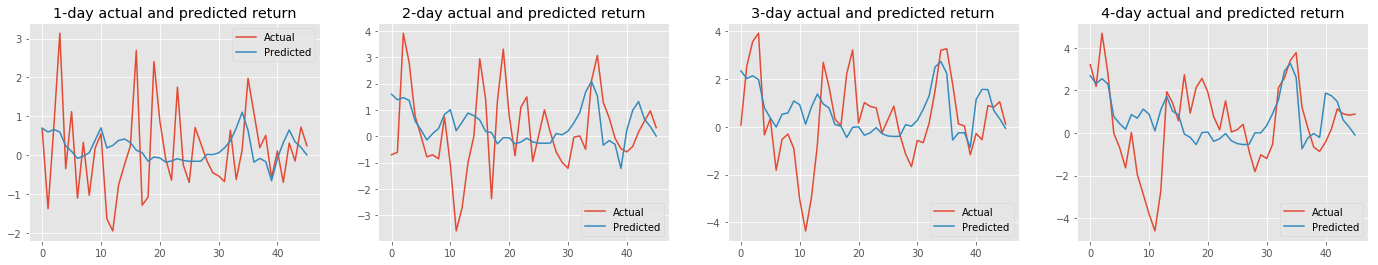

In [15]:
# Plot the actual and predicted returns in the out-of-sample part.
_, ax = plt.subplots(nrows=1, ncols=4,figsize=(24,4))
for i in range(y_size):
    ax[i].set_title(str(i+1)+'-day actual and predicted return')
    ax[i].plot(y_test[:,i],label='Actual')
    ax[i].plot(y_pred[:,i],label='Predicted')
    ax[i].legend()

## Conclusions

The quality of the prediction isn't really good. 
- The RMSE increased from 1.10 to 1.80 as the returns cumulated. However, we've scaled the returns to fit for the LSTM model and such amount of RMSE isn't actually promising. 
- The correlation grew from 0.11 to 0.42, which means the predictions of cumulative returns become more useful as time goes by but still cannot be seen as a good result.
- From the figure above, we learn that our prediciton gradually fits the actual returns as the the cumulates. However, we cannot say the quality of prediction is good.
